In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

# Some plotting config
seaborn.set(
    context="notebook",
    # style="ticks",
    style="darkgrid",
    font="Times New Roman",
    font_scale=1.5,
)
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
# plt.rcParams["xtick.top"] = True
# plt.rcParams["ytick.right"] = True
# plt.rcParams["xtick.bottom"] = True
# plt.rcParams["ytick.left"] = True
plt.rcParams["mathtext.fontset"] = "cm"

from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import limepy

import numpy as np
import scipy as sp
import pandas as pd
import astropy.units as u
import astropy.constants as const

from binaryshift import BinaryShift
import binaryshift

import fitter
from fitter import Observations
from fitter import Model
import fnmatch
import string
import scipy
import warnings

In [2]:
obs = Observations("NGC0104")

In [55]:
theta = [6.0, 0.88, 6.82, 1.33, 1.03, 0.37, 0.01, 3.49, 0.5, 1.5, 2.15, 0.13, 4.42]

In [56]:
model = Model(
    theta=theta,
    observations=obs,
)

/home/peter/anaconda3/envs/gcfit/lib/python3.9/site-packages/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [57]:
model.rhoj

<Quantity [[2.61790649e+01, 2.61790647e+01, 2.61790387e+01, ...,
            1.20044655e-20, 1.48124247e-23, 0.00000000e+00],
           [5.22262807e+01, 5.22262803e+01, 5.22262239e+01, ...,
            1.92793667e-20, 2.37889949e-23, 0.00000000e+00],
           [1.10438304e+02, 1.10438302e+02, 1.10438169e+02, ...,
            3.02159620e-20, 3.72837646e-23, 0.00000000e+00],
           ...,
           [2.37182790e+02, 2.37182782e+02, 2.37181843e+02, ...,
            7.88967448e-23, 9.73514546e-26, 0.00000000e+00],
           [2.96422864e+02, 2.96422854e+02, 2.96421627e+02, ...,
            6.07314851e-23, 7.49371657e-26, 0.00000000e+00],
           [9.88752044e-02, 9.88752010e-02, 9.88747918e-02, ...,
            2.02459787e-26, 2.49817085e-29, 0.00000000e+00]] solMass / pc3>

In [58]:
model.mj[model._single_mask]

<Quantity [0.11847829, 0.16346801, 0.22554166, 0.31118651, 0.42935326,
           0.53588673, 0.61557221, 0.70710678, 0.79994453, 0.61557221,
           0.70710678, 0.79994453, 0.91889497, 1.1188027 , 1.40848915,
           3.53796479, 4.45403378, 5.60729631, 7.05916782] solMass>

In [59]:
model.Mj

<Quantity [1.14563615e+04, 1.91420676e+04, 3.17131140e+04, 5.38465342e+04,
           8.88519780e+04, 4.79627790e+04, 5.41188985e+04, 5.81657293e+04,
           4.84534748e+04, 1.46991111e+05, 1.18060247e+05, 2.70397141e+04,
           2.78381184e+04, 6.32426806e+04, 8.72289787e+03, 1.51181692e+01,
           2.82864384e+01, 5.64936590e+01, 1.23340169e+02, 3.52139163e+03,
           3.46365473e+03, 5.70374934e+03, 6.57875408e+03, 6.46917515e+03,
           1.08892544e+04, 6.77624773e+03, 6.52675461e+03, 6.87629344e+03,
           3.02314724e+03, 5.30887105e+03, 3.61622059e+03, 3.25644408e+03,
           1.04818807e+03, 1.11253880e+03, 3.71031238e-01] solMass>

In [60]:
len(model.Mj)

35

In [61]:
model.rhoj[model._single_mask]

<Quantity [[2.61790649e+01, 2.61790647e+01, 2.61790387e+01, ...,
            1.20044655e-20, 1.48124247e-23, 0.00000000e+00],
           [5.22262807e+01, 5.22262803e+01, 5.22262239e+01, ...,
            1.92793667e-20, 2.37889949e-23, 0.00000000e+00],
           [1.10438304e+02, 1.10438302e+02, 1.10438169e+02, ...,
            3.02159620e-20, 3.72837646e-23, 0.00000000e+00],
           ...,
           [5.23176907e+01, 5.23176869e+01, 5.23172252e+01, ...,
            1.19614631e-29, 1.47593663e-32, 0.00000000e+00],
           [1.45473860e+02, 1.45473848e+02, 1.45472325e+02, ...,
            2.17051734e-31, 2.67822267e-34, 0.00000000e+00],
           [4.35583514e+02, 4.35583469e+02, 4.35578064e+02, ...,
            1.53723954e-33, 1.89681506e-36, 0.00000000e+00]] solMass / pc3>

In [62]:
def flatten(t):
    """
    Flatten a nested list
    https://stackoverflow.com/a/952952/13577036
    """
    return [item for sublist in t for item in sublist]

In [63]:
def rescale_densities(model):

    # make copy of density profile, Mj
    rescaled_rhoj = model.rhoj[model._single_mask].copy()
    rescaled_Sigmaj = model.Sigmaj[model._single_mask].copy()
    scaled_Mj = model.Mj[model._single_mask].copy()

    # get binaries
    binaries = flatten(model._binshift.q_values)

    # get isochrone
    isochrone = binaryshift.gcfit.get_isochrone(model)

    # loop through each binary population
    for binary in binaries:

        # find "observed" mass
        observed_mass = (
            binaryshift.gcfit.get_observed_mass(
                isochrone=isochrone, mj=binary.mj, q=binary.q
            )
            << u.Msun
        )

        # find closest mass bin
        closest_idx = np.argmin(np.abs(model.mj[model._single_mask] - observed_mass))

        # scale the corresponding density bin

        # find scale factor
        scale_factor = (scaled_Mj[closest_idx] + binary.Mj * u.Msun) / scaled_Mj[
            closest_idx
        ]
        # apply scale
        scaled_Mj[closest_idx] *= scale_factor
        rescaled_rhoj[closest_idx] *= scale_factor
        rescaled_Sigmaj[closest_idx] *= scale_factor

        # add rescaled density profiles to model
        model.rescaled_rhoj = rescaled_rhoj
        model.rescaled_Sigmaj = rescaled_Sigmaj

In [64]:
# %%timeit
# rescale_densities(model)

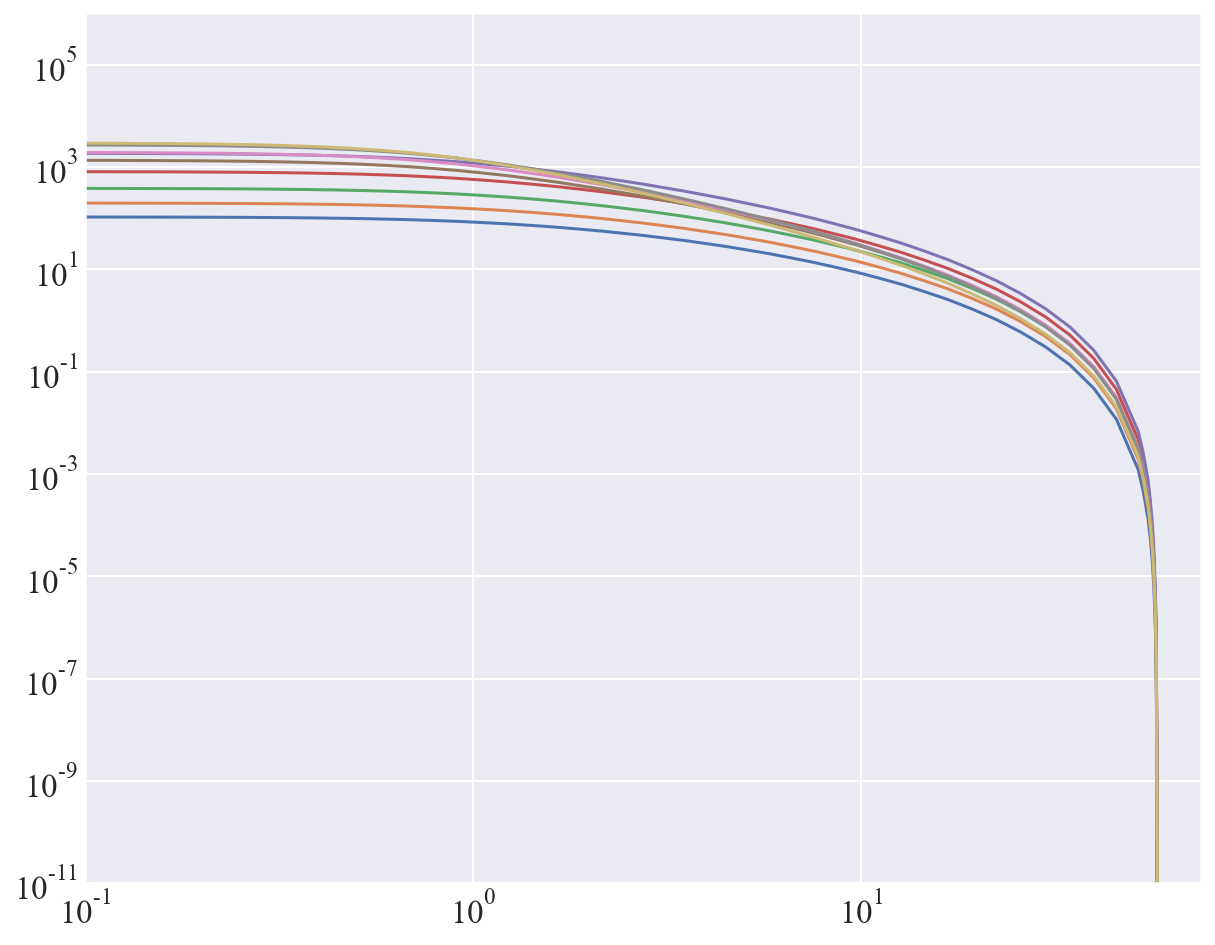

In [65]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 75)
plt.ylim(1e-11, 1e6)
for i in range(len(model.Sigmaj[np.r_[model._binshift.MS_mask, [False]]])):
    plt.plot(model.r, model.Sigmaj[i])

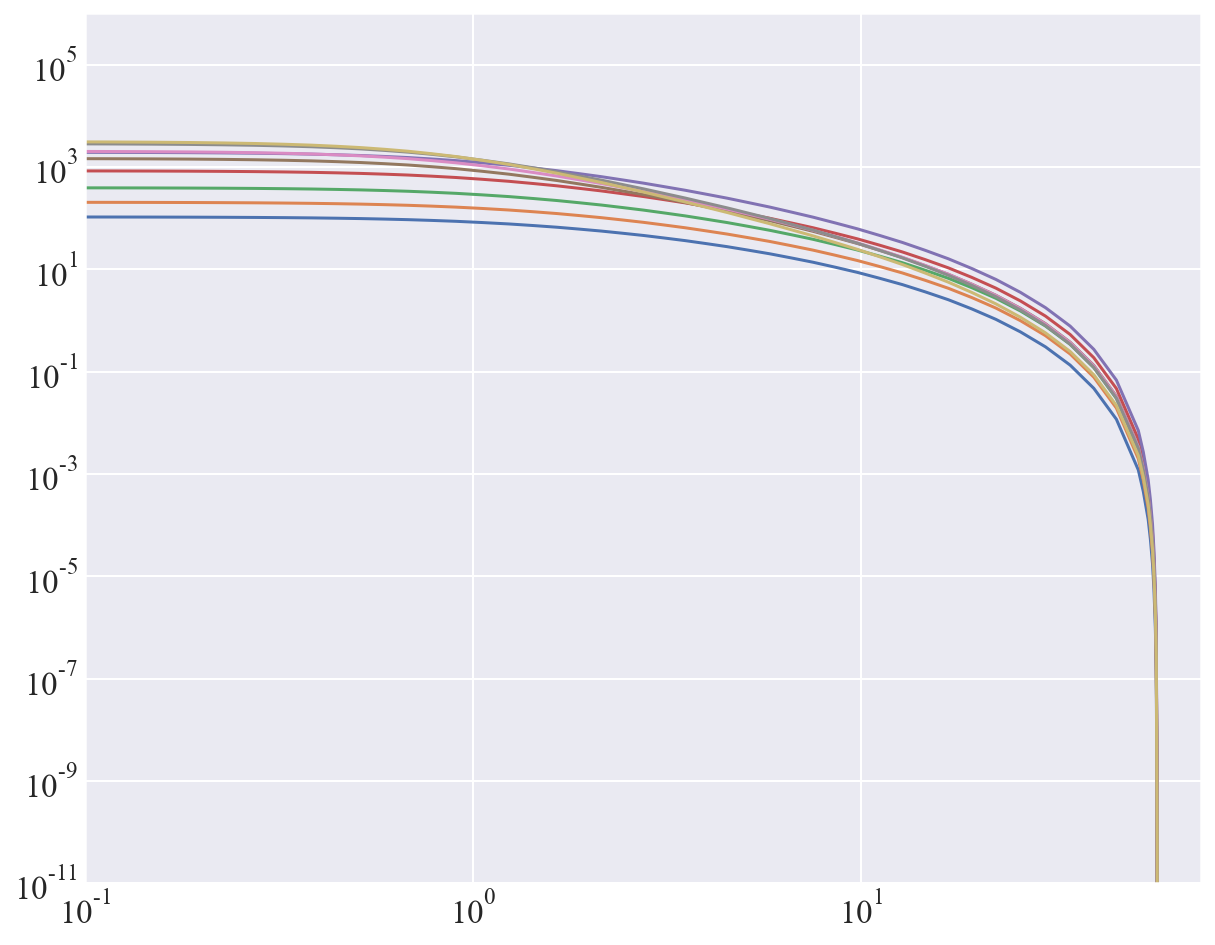

In [66]:
plt.figure()
plt.loglog()
plt.xlim(1e-1, 75)
plt.ylim(1e-11, 1e6)
for i in range(len(model.rescaled_Sigmaj[np.r_[model._binshift.MS_mask, [False]]])):
    plt.plot(model.r, model.rescaled_Sigmaj[i])

In [67]:
len(model.rhoj)

35

In [68]:
len(model.rescaled_Sigmaj)

35

# Need to test that this is correct 

In [69]:
np.sum(model.Sigmaj)

<Quantity 884793.56757535 solMass / pc2>

In [70]:
np.sum(model.rescaled_Sigmaj)

<Quantity 898606.01332422 solMass / pc2>

In [71]:
eqvs = fitter.util.angular_width(model.d)

u.set_enabled_equivalencies(eqvs)

### This looks super close? Is it just a precision problem or is something broken? 

In [90]:
# MF calculation being used in old version


def get_Mass(model, Sigmaj, j):

    # force full region
    r1, r2 = model.r[0].value, model.r[-1].value

    # Interpolate the model density at the data locations
    density = scipy.interpolate.UnivariateSpline(
        model.r.value, 2 * np.pi * model.r.value * Sigmaj[j].value, k=3, s=2
    )

    # Integrate density
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    Mass = scipy.integrate.quad(density, r1, r2, limit=150)[0]

    return Mass

In [91]:
len(model.mj)

35

In [92]:
sum_original = 0
for i in range(len(model.Sigmaj)):
    sum_original += get_Mass(model, model.Sigmaj, i)

In [93]:
sum_rescaled = 0
for i in range(len(model.rescaled_Sigmaj)):
    M = get_Mass(model, model.rescaled_Sigmaj, i)
    sum_rescaled += M

In [94]:
sum_original

865476.3666646223

In [95]:
sum_rescaled

885079.0404020377

In [96]:
sum_rescaled / sum_original

1.02264957714901

In [97]:
sum_original / sum_rescaled

0.9778520642308838

In [89]:
# this doesnt *quite* match up, hard to tell if this is fine or actually some issue with the rescaling